# Latency and Throughput per Packet

In this notebook, we take the schedules we generated and graph the latency of each packet v.s. number of mules and the throughput of each packet v.s. number of mules. We do this for both naive uploads and for batched uploads to see the effect that batching has on latency and throughput. Since batching delays uploads and limits the amount of data per upload, we expect latency to increase and throughput to decrease when we introduce batching.

## Latency

We start by calculating latency for each packet delivered. Note that this does not include packets that are not delivered. Wild.

Latency is the time between data generation and packet upload time.

In [25]:
# Import libraries.
import csv
import math
import numpy as np
import pandas as pd
from matplotlib import cm as cm
from matplotlib import pyplot as plt

In [2]:
schedule_df = pd.read_csv('prob_data/random_uploads/schedule.csv', skiprows=3)
schedule_df.head()


,sensor_id,mule_id,sample_time,pickup_time,batch_time,data_length
0,697,0,0.0,1.501024,122,128
1,977,0,0.0,1.501024,122,128
2,624,0,0.0,3.501024,122,128
3,638,0,0.0,7.501024,122,128
4,17,0,20.0,20.001024,122,128


In [3]:
schedule_df['naive_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time']
schedule_df['batch_latency'] = schedule_df['batch_time'] - schedule_df['sample_time']

In [6]:
t_grain = 50
longest_latency = schedule_df['batch_latency'].max()
num_bins = math.ceil(longest_latency / t_grain)
t_edges = [t * t_grain for t in range(num_bins+1)]

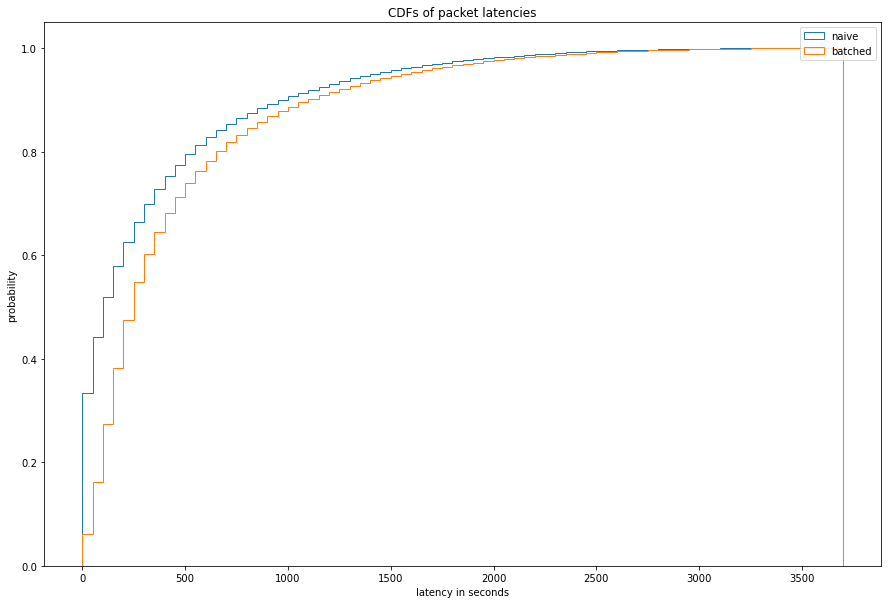

In [11]:
plt.figure(figsize=(15,10))
plt.hist(schedule_df['naive_latency'], bins=t_edges, density=True, cumulative=True, histtype='step', label='naive')
plt.hist(schedule_df['batch_latency'], bins=t_edges, density=True, cumulative=True, histtype='step', label='batched')
plt.legend()
plt.title('CDFs of packet latencies')
plt.xlabel('latency in seconds')
plt.ylabel('probability')
plt.show()

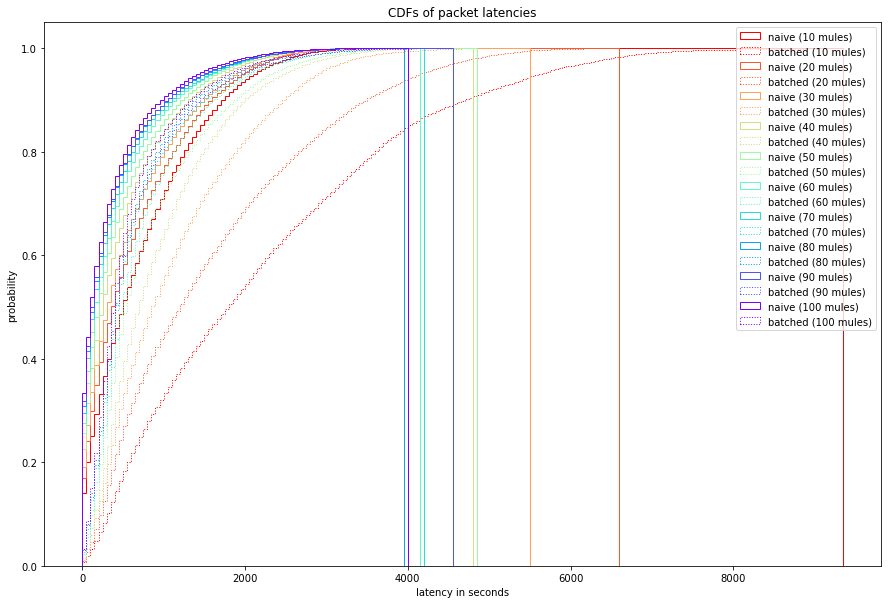

In [14]:
# do the same thing with multiple number of mules
num_mules_list = [10, 20, 30, 40, 50, 60, 70 ,80, 90, 100] # integer <= 100
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'
colors = cm.rainbow(np.linspace(1, 0, len(num_mules_list)))
t_grain = 50

plt.figure(figsize=(15,10))

for index, num_mules in enumerate(num_mules_list):
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    schedule_df['naive_latency'] = schedule_df['pickup_time'] - schedule_df['sample_time']
    schedule_df['batch_latency'] = schedule_df['batch_time'] - schedule_df['sample_time']
    
    longest_latency = schedule_df['batch_latency'].max()
    num_bins = math.ceil(longest_latency / t_grain)
    t_edges = [t * t_grain for t in range(num_bins+1)]
    
    plt.hist(schedule_df['naive_latency'], bins=t_edges, density=True, cumulative=True, histtype='step', color=colors[index], linestyle='-', label='naive ({} mules)'.format(num_mules))
    plt.hist(schedule_df['batch_latency'], bins=t_edges, density=True, cumulative=True, histtype='step', color=colors[index], linestyle=':', label='batched ({} mules)'.format(num_mules))

plt.legend()
plt.title('CDFs of packet latencies')
plt.xlabel('latency in seconds')
plt.ylabel('probability')
plt.show()


Ok, this is super ugly but whatever. Good enough for now.

## Throughput

Now we plot out throughput over number of mules, where throughput is average number of packets uploaded within the hour?

In [15]:
schedule_df = pd.read_csv('prob_data/random_uploads/schedule.csv', skiprows=3)
schedule_df.head()

,sensor_id,mule_id,sample_time,pickup_time,batch_time,data_length
0,697,0,0.0,1.501024,122,128
1,977,0,0.0,1.501024,122,128
2,624,0,0.0,3.501024,122,128
3,638,0,0.0,7.501024,122,128
4,17,0,20.0,20.001024,122,128


In [18]:
sum(schedule_df['pickup_time'] < 3600)


267467

In [19]:
sum(schedule_df['batch_time'] < 3600)


256854

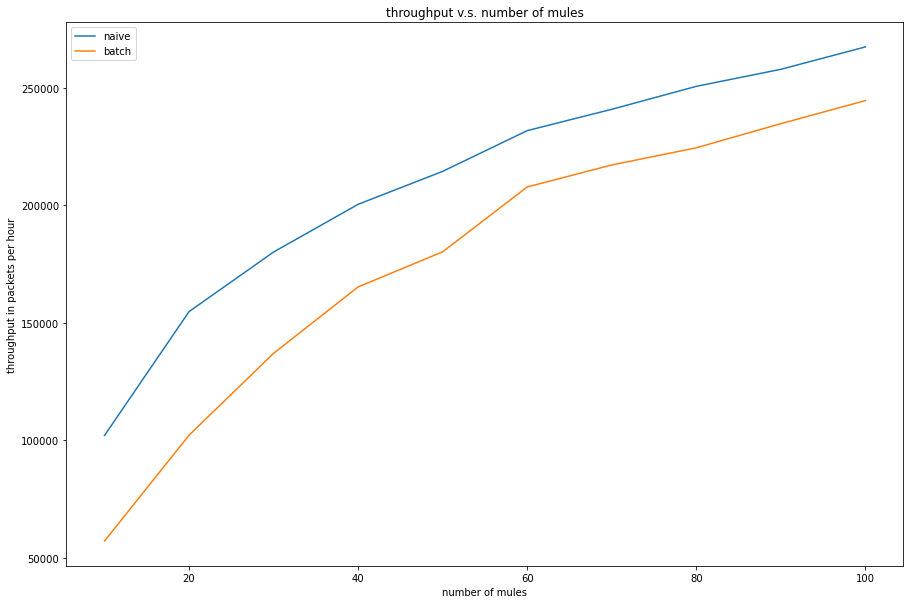

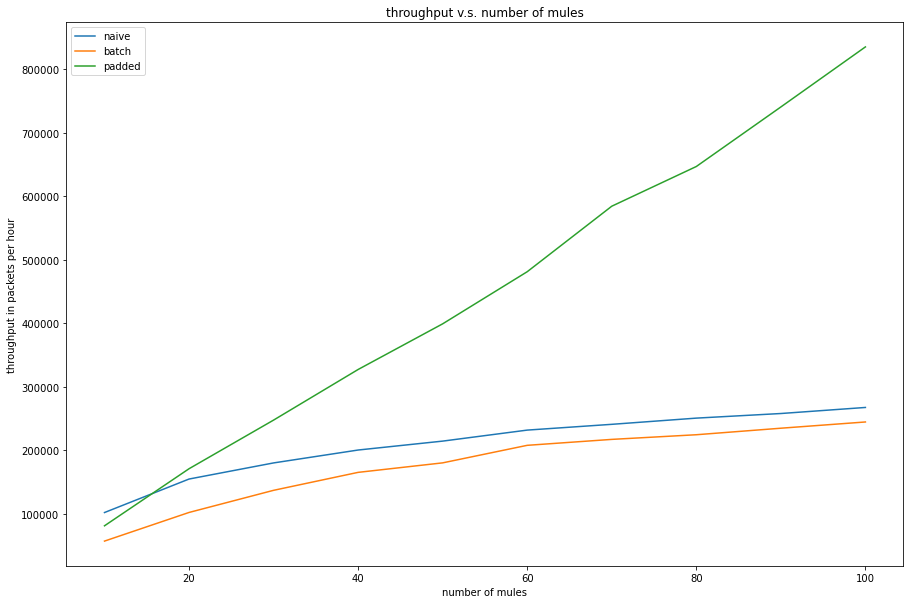

In [30]:
# do the same thing with multiple number of mules
num_mules_list = [10, 20, 30, 40, 50, 60, 70 ,80, 90, 100] # integer <= 100
schedule_file = 'prob_data/random_uploads/vary_mules/{}_mule_schedule.csv'
dummy_file = 'prob_data/random_uploads/vary_mules/{}_mule_dummy.csv'

naive_throughput = []
batch_throughput = []
padded_throughput = []

for num_mules in num_mules_list:
    schedule_df = pd.read_csv(schedule_file.format(num_mules), skiprows=3)
    naive_throughput.append(sum(schedule_df['pickup_time'] < 3600))
    batch_throughput.append(sum(schedule_df['batch_time'] < 3600))
    
    with open(dummy_file.format(num_mules), 'r') as f:
        reader = csv.DictReader(f)
        for row in reader:
            samples_per_batch = int(row['samples_per_batch'])
            break
    dummy_df = pd.read_csv(dummy_file.format(num_mules), skiprows=2)
    padded_throughput.append(sum(dummy_df['batch_time'] < 3600) * samples_per_batch)

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_throughput, label='naive')
plt.plot(num_mules_list, batch_throughput, label='batch')
plt.legend()
plt.title('throughput v.s. number of mules')
plt.xlabel('number of mules')
plt.ylabel('throughput in packets per hour')
plt.show()

plt.figure(figsize=(15,10))
plt.plot(num_mules_list, naive_throughput, label='naive')
plt.plot(num_mules_list, batch_throughput, label='batch')
plt.plot(num_mules_list, padded_throughput, label='padded')
plt.legend()
plt.title('throughput v.s. number of mules')
plt.xlabel('number of mules')
plt.ylabel('throughput in packets per hour')
plt.show()


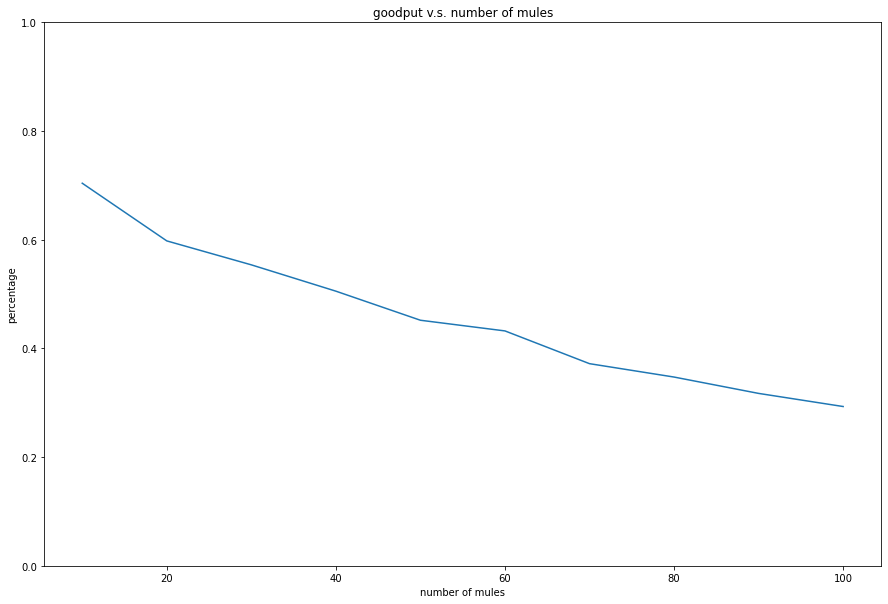

In [29]:
goodput = [batch/pad for batch, pad in zip(batch_throughput, padded_throughput)]
plt.figure(figsize=(15,10))
plt.plot(num_mules_list, goodput)
plt.title('goodput v.s. number of mules')
plt.xlabel('number of mules')
plt.ylabel('percentage')
plt.ylim(0, 1)
plt.show()